In [1]:
############################################
import pandas as pd
from itertools import combinations
from collections import defaultdict
from blocking_utils.blocking_utils import compute_similarity
from datasketch import MinHash, MinHashLSH
from nltk.util import ngrams
import multiprocessing as mp
import logging
import time
import numpy as np
from tqdm import tqdm
import random
df = None
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler()],
)
logger = logging.getLogger(__name__)
start_total = time.time()

def get_all_pairs(cluster_dict):
    pairs = set()
    for records in cluster_dict.values():
        if len(records) > 1:
            pairs.update(combinations(sorted(records), 2))
    return pairs


def compute_similarity_pair(pair):
    """
    Computes the similarity score for a given pair of record IDs.
    Accesses the global DataFrame 'df'.
    """
    record_id1, record_id2 = pair
    # Access the global DataFrame
    global df
    try:
        row1 = df.loc[record_id1]
        row2 = df.loc[record_id2]
        sim_score = compute_similarity(row1, row2)
        return (pair, sim_score)
    except Exception as e:
        logger.error(f"Error computing similarity for pair {pair}: {e}")
        return (pair, 0.0)



def create_ngram_lsh_parallel(
    df_local, colname, n=3, threshold=0.5, num_perm=128, num_processes=4
):
    logger.info(f"Creating parallel LSH for column: {colname}")
    start_time = time.time()

    # Initialize LSH
    ngram_lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    ngram_minhashes = {}

    # Split DataFrame into chunks
    num_chunks = num_processes
    chunks = np.array_split(df_local, num_chunks)

    # Prepare arguments for each chunk
    args = [(chunk, colname, n, num_perm) for chunk in chunks]

    # Use Pool to compute MinHashes in parallel
    with mp.Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap(compute_minhash_chunk, args), total=len(args), desc="Processing Chunks"))

        results = pool.map(compute_minhash_chunk, args)
    with ngram_lsh.insertion_session() as session:
    # Collect MinHashes and insert into LSH
        for partial_minhashes in results:
            for record_id, m in partial_minhashes.items():
                ngram_minhashes[record_id] = m
                session.insert(record_id, m)

    logger.info(
        f"Parallel LSH creation for column {colname} completed in {time.time() - start_time:.2f} seconds."
    )
    return ngram_lsh, ngram_minhashes


def compute_minhash_chunk(args):
    """
    Computes MinHash signatures for a chunk of the DataFrame.
    """
    chunk, colname, n, num_perm = args
    from nltk.util import ngrams
    from datasketch import MinHash
    import pandas as pd

    def text_to_ngrams(text, n):
        text = text.lower().replace(" ", "")
        return set("".join(ng) for ng in ngrams(text, n))

    partial_minhashes = {}
    for idx, row in tqdm(chunk.iterrows()):
        col = row[colname]
        record_id = row["record_id"]

        if pd.isnull(col):
            continue

        col_ngrams = text_to_ngrams(col, n)

        m = MinHash(num_perm=num_perm)
        for ngram in col_ngrams:
            m.update(ngram.encode("utf8"))

        partial_minhashes[record_id] = m
    return partial_minhashes


def create_minhash_text_based(text, n, num_perm=128):
    text = text.lower().replace(" ", "")
    col_ngrams = set("".join(ng) for ng in ngrams(text, n))
    
    # col_ngrams = text_to_ngrams(col, n)

    m = MinHash(num_perm=num_perm)
    for ngram in col_ngrams:
        m.update(ngram.encode("utf8"))
    return m


def init_worker(dataframe):
    """
    Initializer for worker processes to set the global DataFrame.
    """
    global df
    df = dataframe

def process_record(record_id, col, lsh_dict, ngram, num_perm):
    """
    Process a single record for LSH and returns composite key and record ID.
    """
    global df
    val = df[col].iloc[record_id]
    if pd.isnull(val):
        return None, None
    try:
        minhash = create_minhash_text_based(val, ngram, num_perm)
        query = lsh_dict[col].query(minhash)
        key = frozenset(query)
        lsh_dict[col].insert(record_id, minhash)
        return key, record_id
    except Exception as e:
        logger.error(f"Error processing record {record_id}: {e}")
        return None, None

global df
df = pd.read_csv("data/processed/external_parties_train.csv")
df["record_id"] = df.index

## Overview

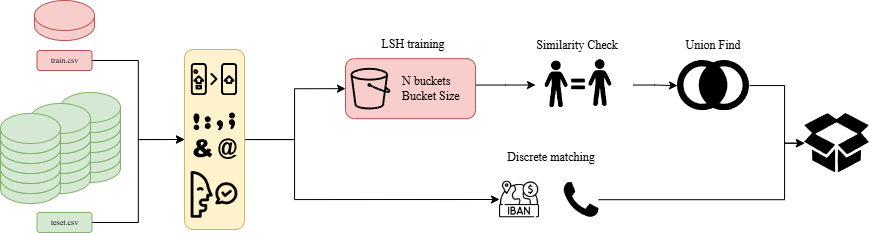

## Feature Engineering

* Removed common name elements: mr, dr, miss, etc.

* Standardized data: lower-case, removed special characters and punctuation, etc.

In [2]:
df[["parsed_name", "name_metaphone", "parsed_address_street_name", "party_phone"]].head()

,parsed_name,name_metaphone,parsed_address_street_name,party_phone
0,mary mith,MR M0,angela brooks,181566067918486
1,yesneia kim,YSN KM,north michael,026962087342349
2,w roberson,RBRSN,rachel crossingapt,NaN
3,azquez nelson co,ASKS NLSN K,ports suite,NaN
4,mj bytd,MJ BTT,john lake s glenn,2603371534


## Locality Sensitive Hashing

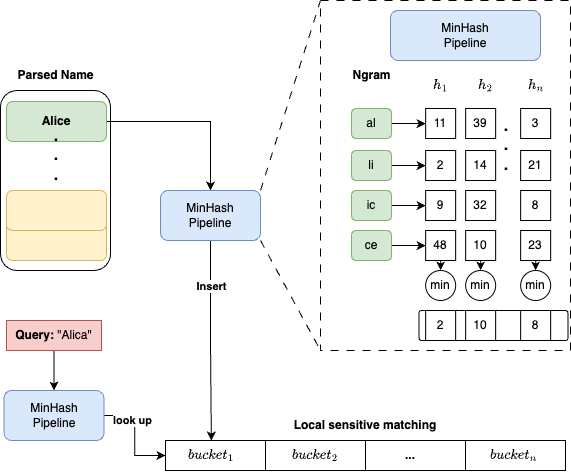

Computational complexity: $O(\text{number of buckets} \times \text{bucket size}^2)$, which is **linear with the number of rows**.

Bucketing Trade-off: 
* Fewer and/or smaller buckets will be **faster** (fewer pairwise comparisons) and have **higher precission** and **lower recall**.

* More and/or larger buckets will **slower** and have **lower precission** and **higher recall**.

* Some buckets are more narrow than others (_given name_ vs. _street name_). A good similarity function is essential.

In [3]:
cols = ["parsed_name", "parsed_address_street_name", "parsed_address_city"]
thres = [0.3, 0.6, 0.6]
ngram = [2, 3, 3]
num_perm = 128

lsh_dict = {
    col: MinHashLSH(threshold=thres[i], num_perm=num_perm) 
    for i, col in enumerate(cols)
}

composite_key_to_records = defaultdict(set)
futures = []
for i, col in enumerate(cols):
    for record_id in df["record_id"]:
        futures.append(
            process_record(record_id, col, lsh_dict, ngram[i], num_perm)
        )

for future in futures:
    key, record_id = future
    if key is not None and record_id is not None:
        composite_key_to_records[key].add(record_id)

candidate_pairs = set()
for records in composite_key_to_records.values():
    if 100 > len(records) > 1:
        candidate_pairs.update(combinations(sorted(records), 2))
    elif len(records) > 100:
        random_records = random.sample(sorted(records), 100)
        candidate_pairs.update(combinations(random_records, 2))

print(f"Generated {len(candidate_pairs)} candidate pairs.")

Generated 5580 candidate pairs.


## Entity Similarity

- Feature-Based Similarity: We calculated similarity scores between rows based on key features like names, phonetics, IBAN, phone numbers, and surname length.
- Weighted Scoring: Each feature was assigned a weight to prioritize its importance in the final similarity calculation.
- Phonetic Matching: Names and surnames were compared using phonetic algorithms (Soundex, Metaphone, NYSIIS) to capture pronunciation-based similarities.
- String Similarity: Jaro-Winkler was used to measure how similar names, surnames, and phone numbers are.
Exact Matches: For features like is_company and party_iban, we checked for direct matches to boost similarity.

In [4]:
%%capture
"""def _compute_similarity(row1, row2):
    # Initialize similarity score
    similarity_score = 0.0
    total_weight = 0.0

    # Define weights for each feature
    weights = {
        "is_company": 2,
        "parsed_name": 10.0,
        "name_phonetic": 10.0,
        "surname": 10.0,
        "surname_phonetic": 5.0,
        "given_name": 1.0,
        "surname_length": 2,
        "party_iban": 1.0,
        "party_phone": 1.0,
    }

    # 1. Compare 'is_company'
    if not pd.isnull(row1["is_company"]) and not pd.isnull(row2["is_company"]):
        if row1["is_company"] == row2["is_company"]:
            similarity_score += weights["is_company"]
        total_weight += weights["is_company"]

    # 2. Compare 'parsed_name' using Jaro-Winkler similarity
    if not pd.isnull(row1["parsed_name"]) and not pd.isnull(row2["parsed_name"]):
        name_similarity = jellyfish.jaro_winkler_similarity(
            row1["parsed_name"], row2["parsed_name"]
        )
        similarity_score += name_similarity * weights["parsed_name"]
        total_weight += weights["parsed_name"]

    # 3. Compare name phonetic encodings
    phonetic_matches = 0
    phonetic_total = 0

    for encoding in ["name_soundex", "name_metaphone", "name_nysiis"]:
        if encoding in row1 and encoding in row2:
            if not pd.isnull(row1[encoding]) and not pd.isnull(row2[encoding]):
                phonetic_total += 1
                if row1[encoding] == row2[encoding]:
                    phonetic_matches += 1

    if phonetic_total > 0:
        phonetic_similarity = phonetic_matches / phonetic_total
        similarity_score += phonetic_similarity * weights["name_phonetic"]
        total_weight += weights["name_phonetic"]

    # 4. Compare 'surname' using Jaro-Winkler similarity
    if not pd.isnull(row1["surname"]) and not pd.isnull(row2["surname"]):
        surname_similarity = jellyfish.jaro_winkler_similarity(
            row1["surname"], row2["surname"]
        )
        similarity_score += surname_similarity * weights["surname"]
        total_weight += weights["surname"]

    # 5. Compare surname phonetic encodings
    surname_phonetic_matches = 0
    surname_phonetic_total = 0

    for encoding in ["surname_soundex", "surname_metaphone", "surname_nysiis"]:
        if encoding in row1 and encoding in row2:
            if not pd.isnull(row1[encoding]) and not pd.isnull(row2[encoding]):
                surname_phonetic_total += 1
                if row1[encoding] == row2[encoding]:
                    surname_phonetic_matches += 1

    if surname_phonetic_total > 0:
        surname_phonetic_similarity = surname_phonetic_matches / surname_phonetic_total
        similarity_score += surname_phonetic_similarity * weights["surname_phonetic"]
        total_weight += weights["surname_phonetic"]

    # 6. Compare 'given_name' using Jaro-Winkler similarity
    if not pd.isnull(row1["given_name"]) and not pd.isnull(row2["given_name"]):
        given_name_similarity = jellyfish.jaro_winkler_similarity(
            row1["given_name"], row2["given_name"]
        )
        similarity_score += given_name_similarity * weights["given_name"]
        total_weight += weights["given_name"]

    # 7. Compare 'surname_length'
    if not pd.isnull(row1["surname_length"]) and not pd.isnull(row2["surname_length"]):
        length_difference = abs(row1["surname_length"] - row2["surname_length"])
        max_length = max(row1["surname_length"], row2["surname_length"])
        if max_length > 0:
            length_similarity = 1 - (length_difference / max_length)
            similarity_score += length_similarity * weights["surname_length"]
            total_weight += weights["surname_length"]

    # 8. Compare 'party_iban' if available
    if "party_iban" in row1 and "party_iban" in row2:
        if not pd.isnull(row1["party_iban"]) and not pd.isnull(row2["party_iban"]):
            if row1["party_iban"] == row2["party_iban"]:
                similarity_score += weights["party_iban"]
            total_weight += weights["party_iban"]

    # 9. Compare 'party_phone' if available
    if "party_phone" in row1 and "party_phone" in row2:
        if not pd.isnull(row1["party_phone"]) and not pd.isnull(row2["party_phone"]):
            phone_similarity = jellyfish.jaro_winkler_similarity(
                row1["party_phone"], row2["party_phone"]
            )
            similarity_score += phone_similarity * weights["party_phone"]
            total_weight += weights["party_phone"]

    # Handle case where total_weight is zero to avoid division by zero
    if total_weight == 0:
        return 0.0

    # Calculate final similarity score as a percentage
    final_similarity = (similarity_score / total_weight)

    return final_similarity"""

In [5]:
similarity_threshold = 0.5
matched_pairs = set()
unmatched_candidate_pairs = []

start_similarity = time.time()

for pair in candidate_pairs:
    first = df.loc[df["record_id"] == pair[0]].iloc[0]
    second = df.loc[df["record_id"] == pair[1]].iloc[0]
    sim_score = compute_similarity(first, second)
    if sim_score >= similarity_threshold:
        matched_pairs.add(pair)
    else:
        unmatched_candidate_pairs.append(pair)

print(
    f"Similarity computation completed in {time.time() - start_similarity:.2f} seconds."
)
print(f"Matched pairs after similarity threshold: {len(matched_pairs)}")

Similarity computation completed in 2.28 seconds.
Matched pairs after similarity threshold: 151


## Deterministic Pairing

In [6]:
# Additional pairing based on 'party_iban' and 'party_phone'
party_iban_to_record_ids = (
    df.groupby("party_iban")["record_id"].apply(list).to_dict()
)
party_phone_to_record_ids = (
    df.groupby("party_phone")["record_id"].apply(list).to_dict()
)

for record_ids in party_iban_to_record_ids.values():
    if len(record_ids) > 1:
        matched_pairs.update(combinations(sorted(record_ids), 2))
for record_ids in party_phone_to_record_ids.values():
    if len(record_ids) > 1:
        matched_pairs.update(combinations(sorted(record_ids), 2))

print(
    f"Total matched pairs after adding IBAN and phone: {len(matched_pairs)}"
)

Total matched pairs after adding IBAN and phone: 6074


In [7]:
# Union-Find implementation
start_union_find = time.time()
parent = {record_id: record_id for record_id in df["record_id"]}

def find(u):
    while parent[u] != u:
        parent[u] = parent[parent[u]]
        u = parent[u]
    return u

def union(u, v):
    pu, pv = find(u), find(v)
    if pu != pv:
        parent[pu] = pv

for u, v in matched_pairs:
    union(u, v)

# Generate clusters
clusters = defaultdict(set)
for record_id in df["record_id"]:
    cluster_id = find(record_id)
    clusters[cluster_id].add(record_id)

# Generate predictions
# df["predicted_external_id"] = df["record_id"].apply(lambda x: find(x))

print(
    f"Clustering completed in {time.time() - start_union_find:.2f} seconds."
)

Clustering completed in 0.01 seconds.


## Results and Evaluation

We first **aggregate pair-matchings with Union-Find**

We evaluated our models on the training data. We do so by by looking at each pair of elements and label our prediction as a: 
* **True Positive**: $i$ and $j$ are the same entity and we predicted so.
* **False Positive**: we predicted $i$ and $j$ as the same entity, which is false.
* **False Negative**: we did not identify $i$ and $j$ as the same entity.

The evaluation metrics we used to guide our modeling are **Precision** and **Recall**

In [8]:
# Ground truth clusters based on 'external_id'
ground_truth = df.groupby("external_id")["record_id"].apply(set).to_dict()

# Get true pairs and predicted pairs
true_pairs = get_all_pairs(ground_truth)
predicted_pairs = get_all_pairs(clusters)

# Compute True Positives (TP), False Positives (FP), and False Negatives (FN)
TP = len(true_pairs.intersection(predicted_pairs))
FP = len(predicted_pairs.difference(true_pairs))
FN = len(true_pairs.difference(predicted_pairs))

# Precision, Recall, F1-Score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = (
    2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Precision: 0.9568
Recall: 0.4886
F1-Score: 0.6469
